In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-mrrougue/pyyaml_c2da6dec4d624c4ca328aa2499ed0d1b/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/dist.py

In [2]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

detectron2 version: 0.6


In [3]:
import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

In [4]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

register_coco_instances(f"bone_fractures", {},
                            f"/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json",
                            f"/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured/")


In [5]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures")
train_dataset_dicts = DatasetCatalog.get("bone_fractures")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [10/24 04:30:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 04:30:07 d2.data.datasets.coco]: Loaded 717 images in COCO format from /kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json


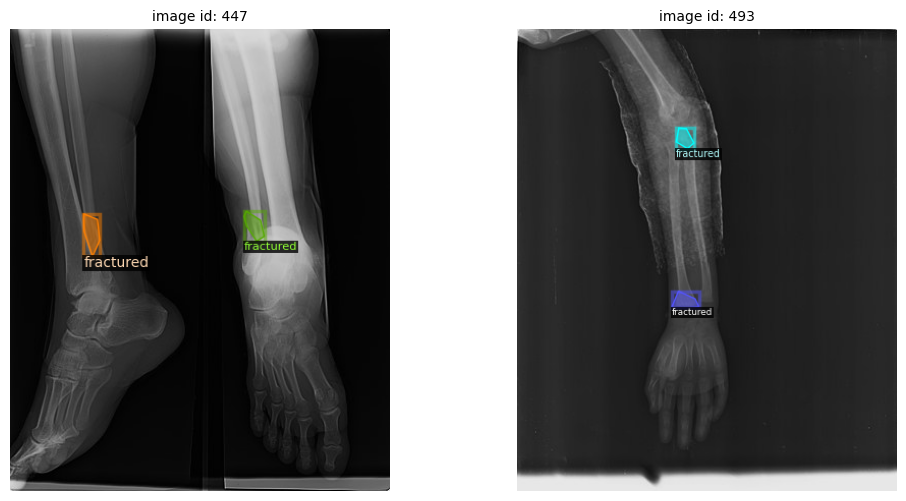

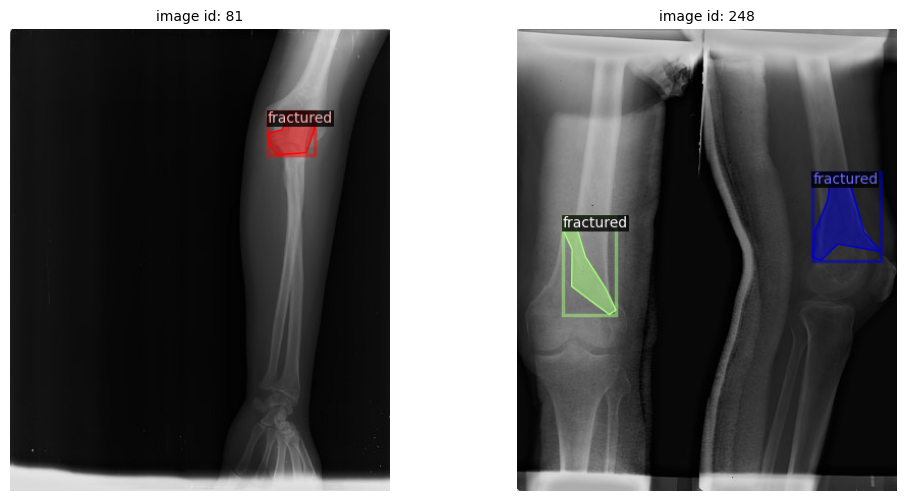

In [6]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 7 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 3 , image_scale = 1)

In [7]:
from detectron2.engine import DefaultTrainer

EPOCHS = 800
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

In [8]:
cfg.DATASETS.TRAIN = ("bone_fractures")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/24 04:30:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:02, 186MB/s]                             


[10/24 04:30:38 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/24 04:31:01 d2.utils.events]:  eta: 0:32:07  iter: 19  total_loss: 2.463  loss_cls: 2.079  loss_box_reg: 0.000332  loss_rpn_cls: 0.3645  loss_rpn_loc: 0.01755    time: 0.9628  last_time: 1.1382  data_time: 0.0262  last_data_time: 0.0046   lr: 1.9981e-05  max_mem: 4596M
[10/24 04:31:32 d2.utils.events]:  eta: 0:24:39  iter: 39  total_loss: 1.599  loss_cls: 1.152  loss_box_reg: 0.001749  loss_rpn_cls: 0.2743  loss_rpn_loc: 0.01604    time: 0.9306  last_time: 0.6422  data_time: 0.0055  last_data_time: 0.0034   lr: 3.9961e-05  max_mem: 4596M
[10/24 04:31:53 d2.utils.events]:  eta: 0:31:22  iter: 59  total_loss: 0.5964  loss_cls: 0.2342  loss_box_reg: 0.01015  loss_rpn_cls: 0.2363  loss_rpn_loc: 0.01153    time: 0.9625  last_time: 1.0777  data_time: 0.0053  last_data_time: 0.0055   lr: 5.9941e-05  max_mem: 4737M
[10/24 04:32:12 d2.utils.events]:  eta: 0:30:58  iter: 79  total_loss: 0.3799  loss_cls: 0.1126  loss_box_reg: 0.03956  loss_rpn_cls: 0.1546  loss_rpn_loc: 0.013    time: 0.9670

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[10/24 05:04:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [10]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [11]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

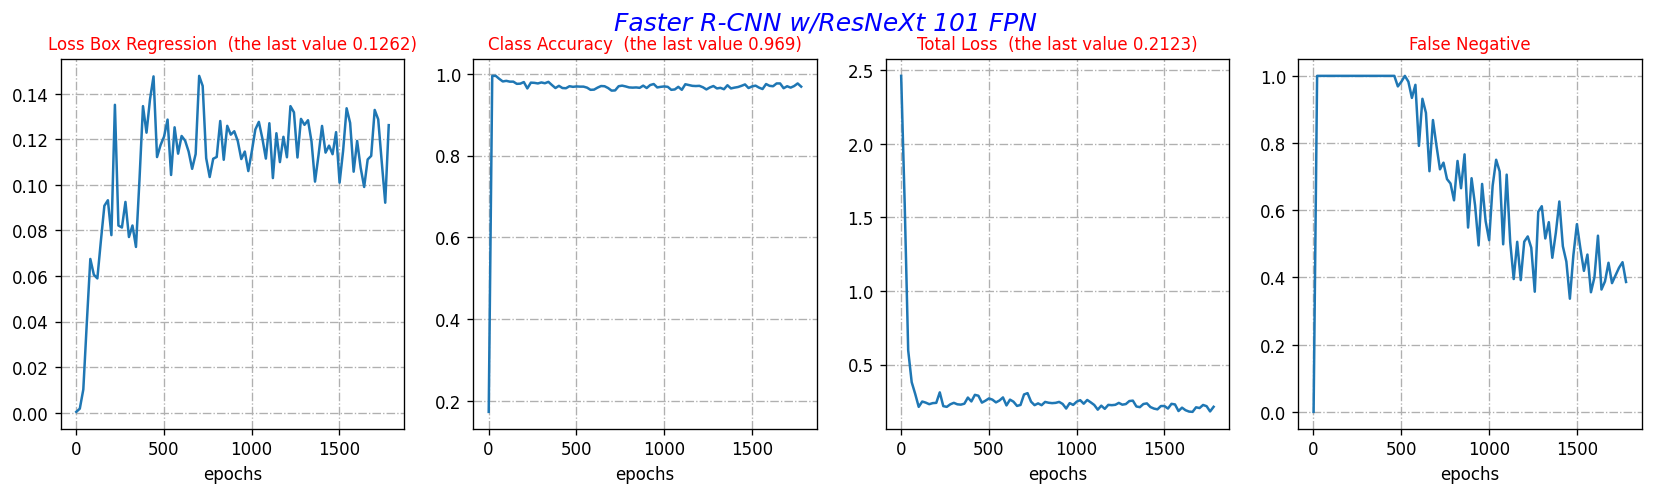

In [12]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [13]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [10/24 05:06:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 05:06:53 d2.data.datasets.coco]: Loaded 717 images in COCO format from /kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json


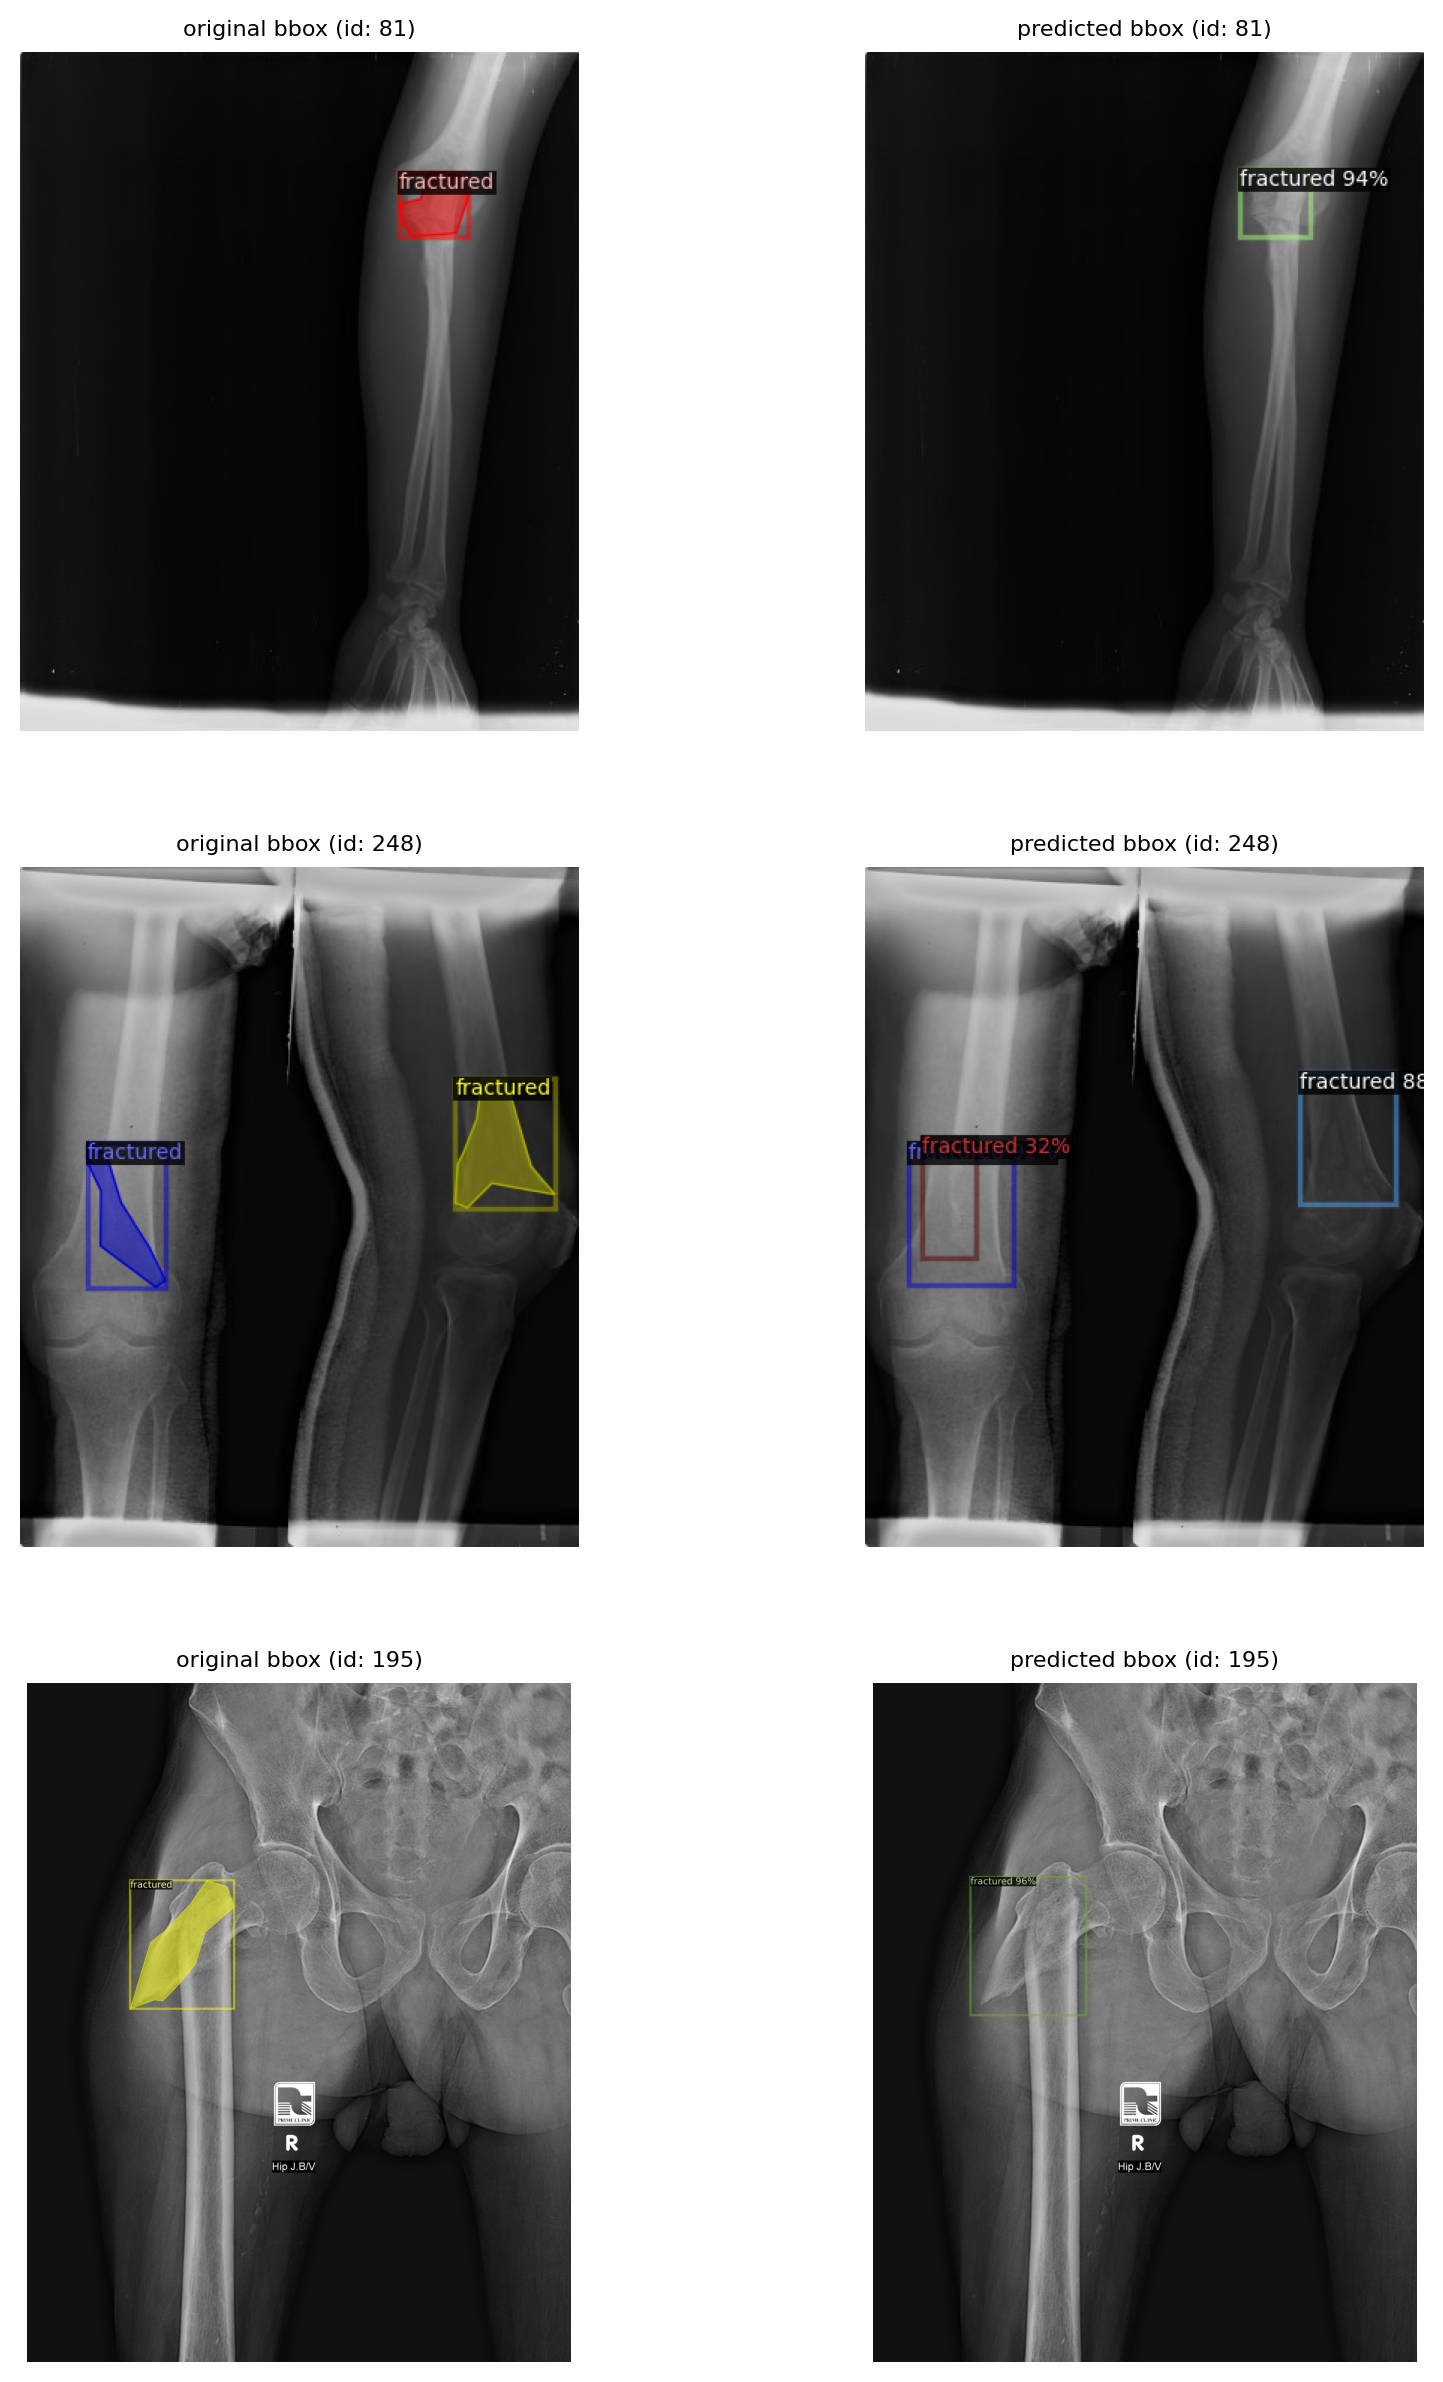

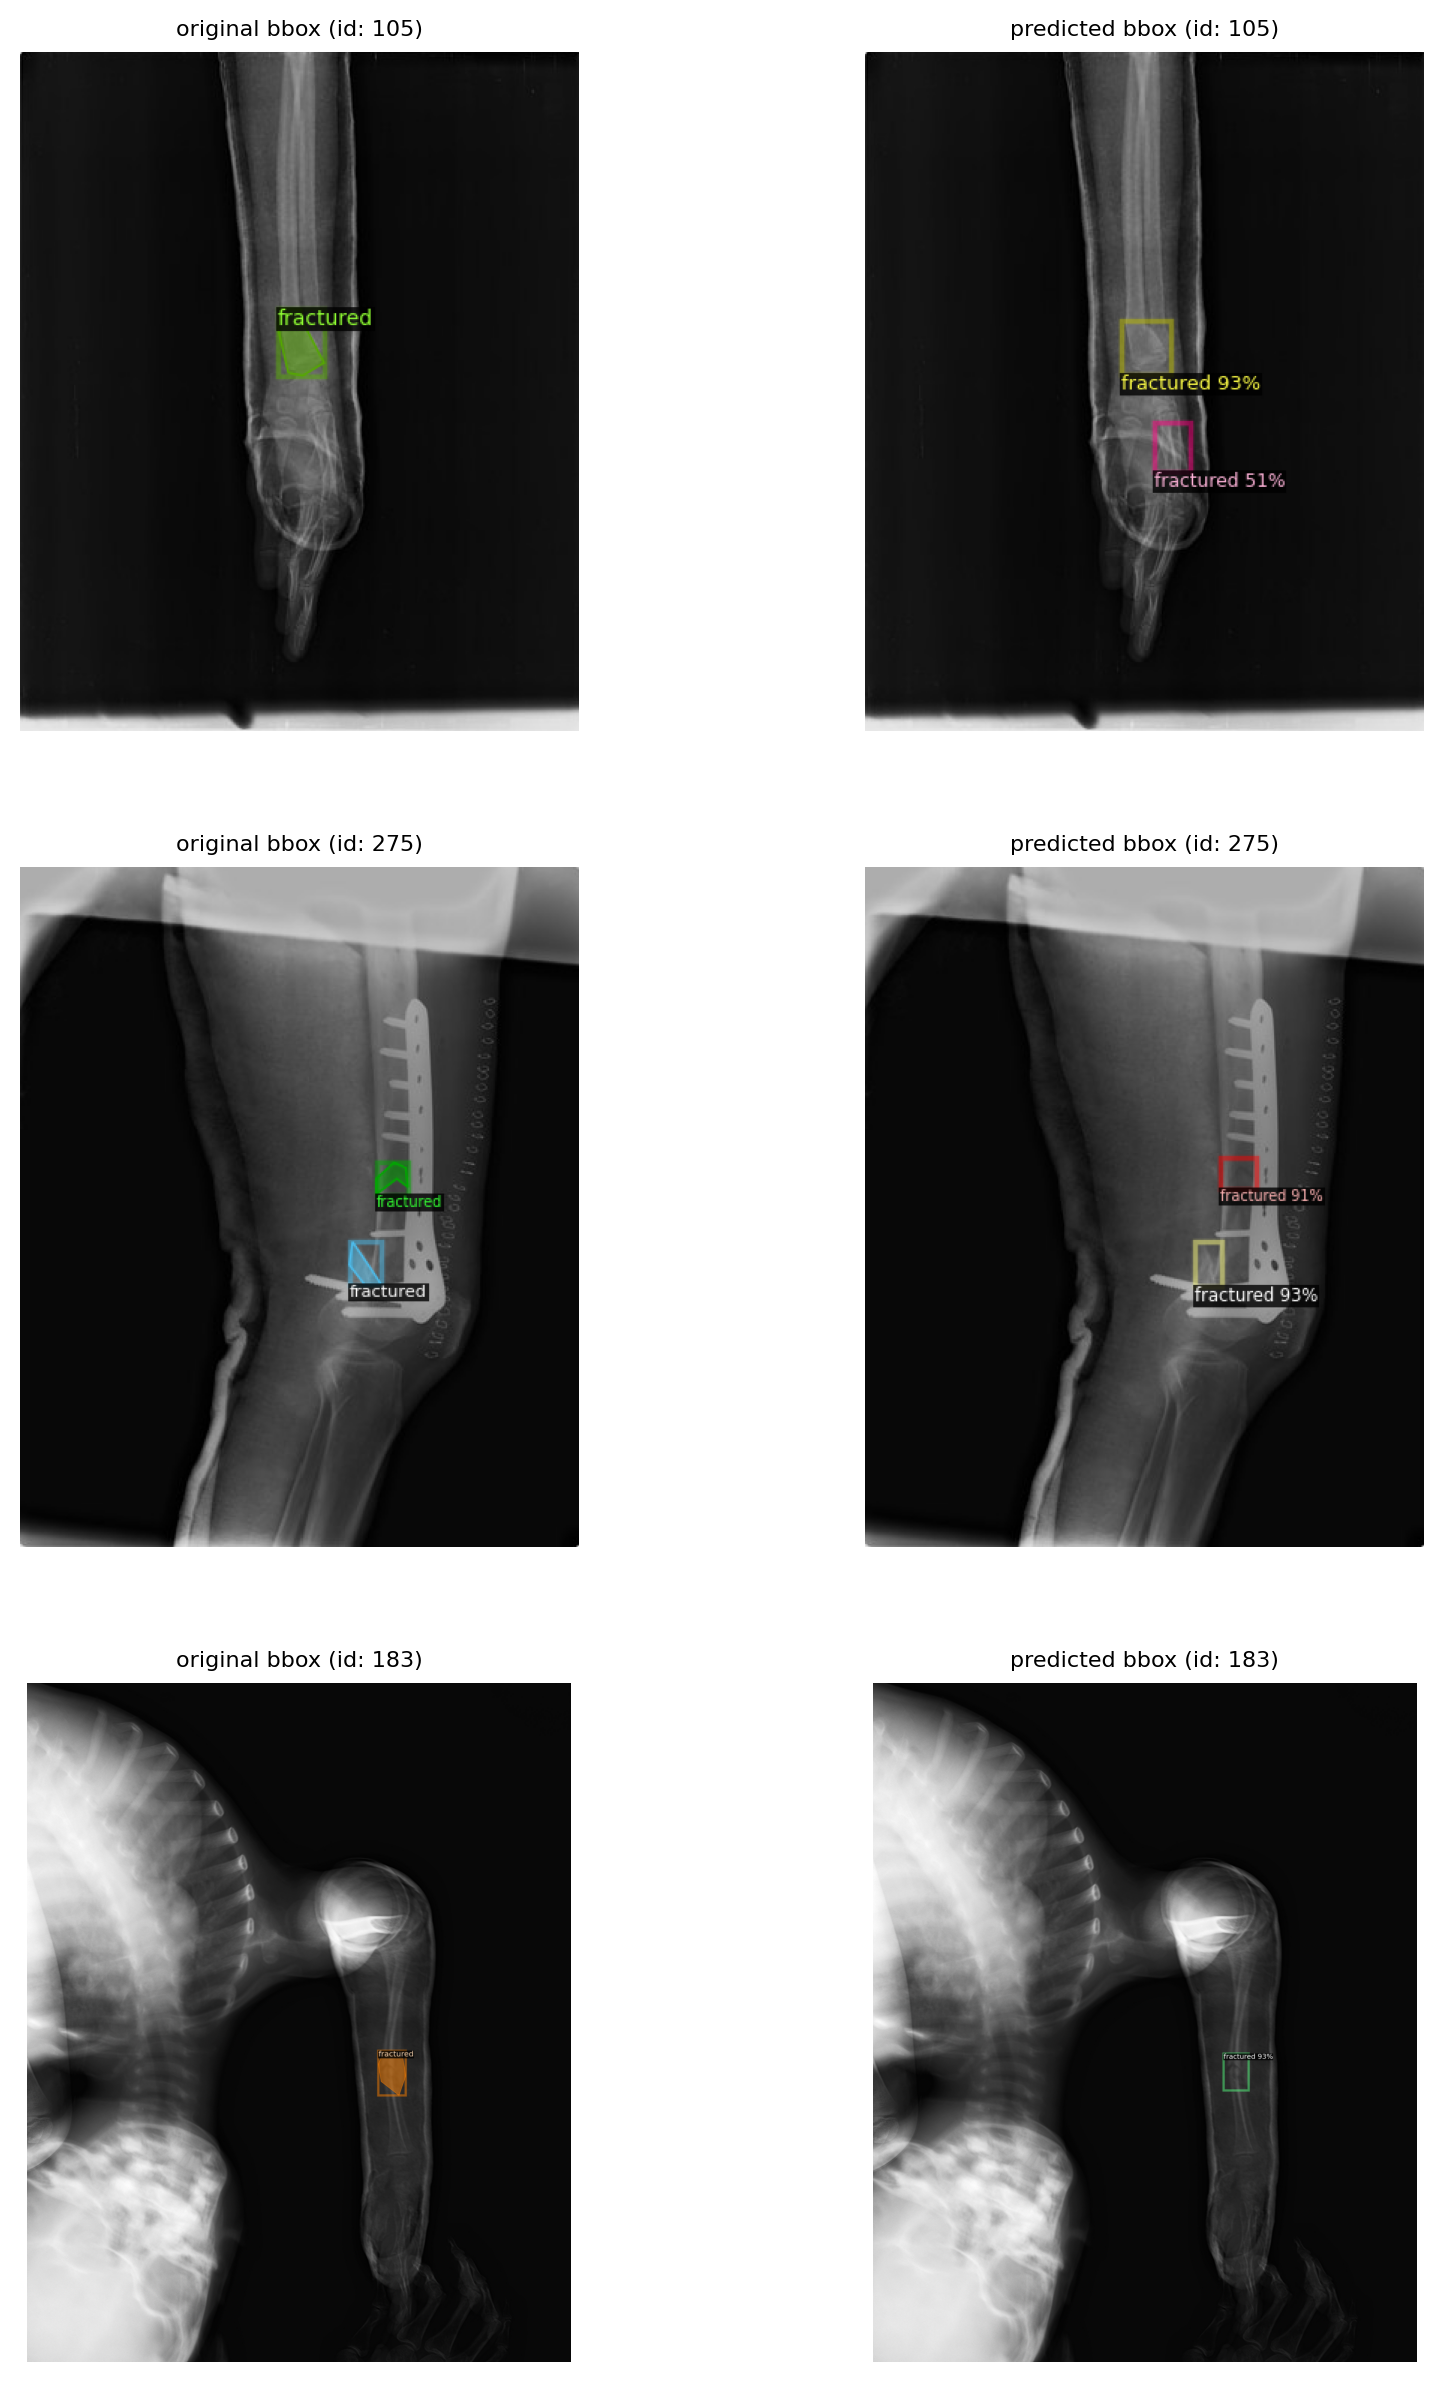

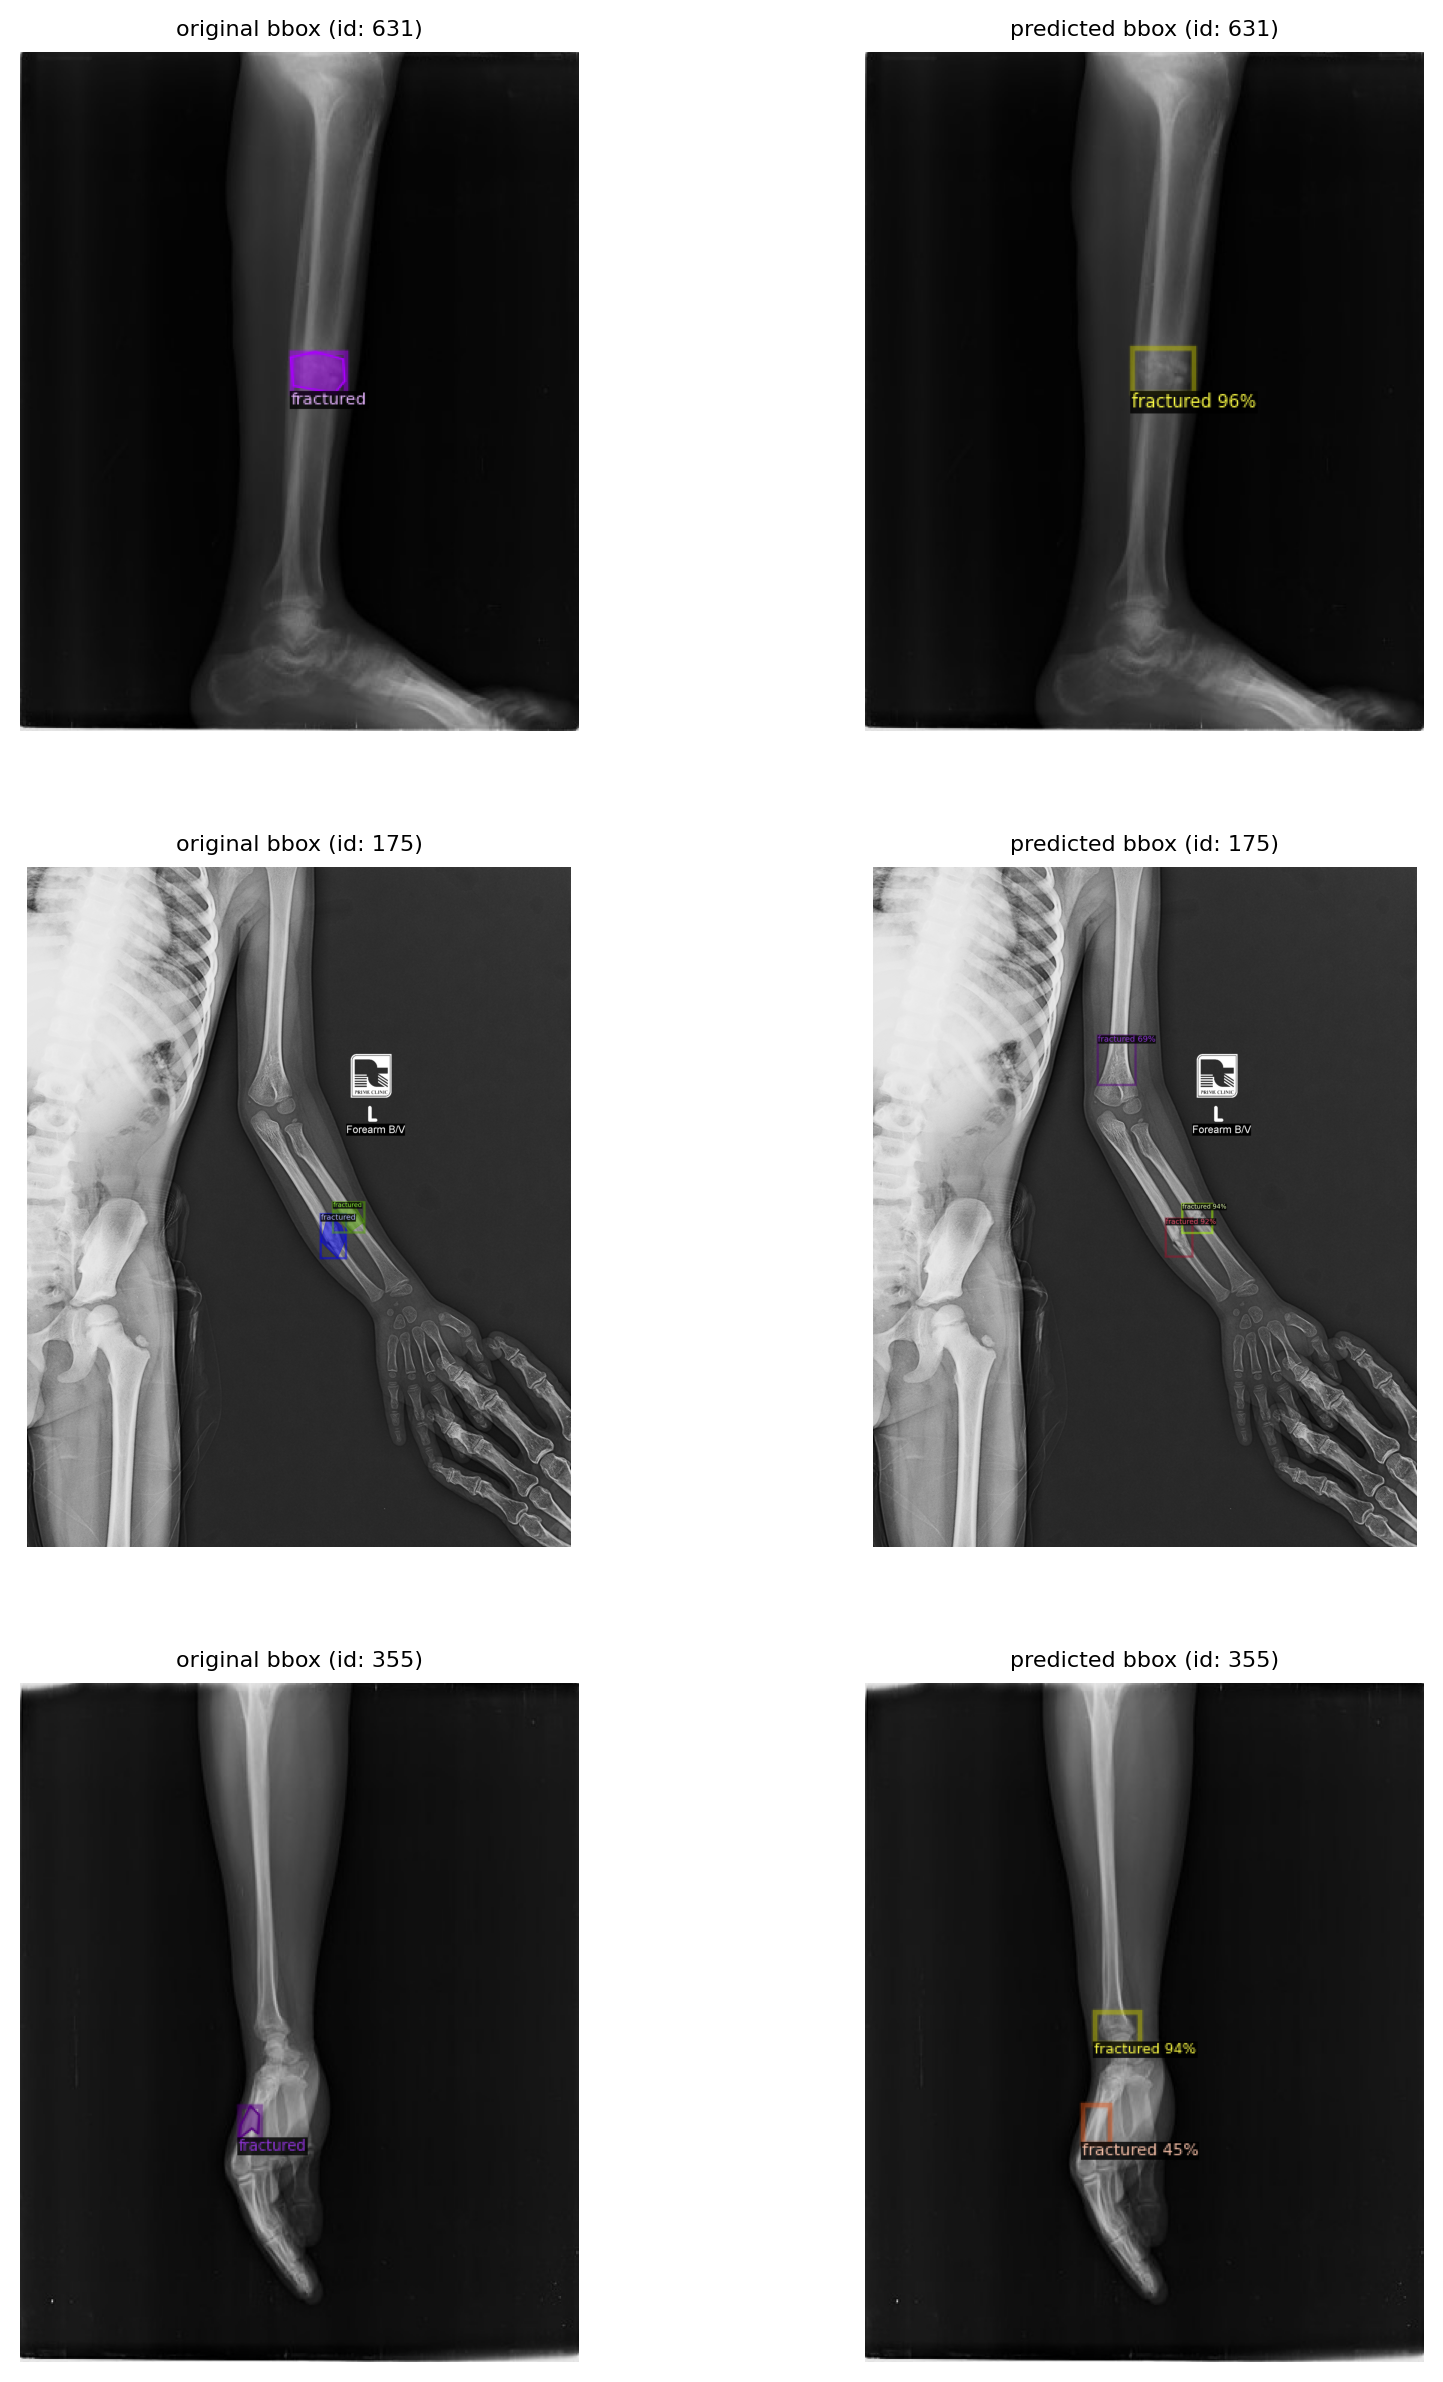

In [14]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 93, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)